In [1]:
import warnings
warnings.filterwarnings('ignore')

# Подготовка и анализ данных

In [104]:
import numpy as np

D_m = 3668582.3189 # cm^-1, converted from 438.86 kJ/mol https://www.weizmann.ac.il/oc/martin/tools/hartree.html
max_vibr_lvls = [9, 17, 9, 20] # vibr_lvls_combinations = [(9, 17, 9, 20), (4, 4, 4, 4), (1, 1, 1, 1)]
om_e = np.array([302550, 158270, 315680, 136740])
ds = np.array([1, 2, 3, 3])

possible_inds = []
for i1 in range(max_vibr_lvls[0]):
    for i2 in range(max_vibr_lvls[1]):
        for i3 in range(max_vibr_lvls[2]):
            for i4 in range(max_vibr_lvls[3]):

                e = (
                    om_e[0] * (i1 + ds[0] / 2.) + 
                    om_e[1] * (i2 + ds[1] / 2.) + 
                    om_e[2] * (i3 + ds[2] / 2.) + 
                    om_e[3] * (i4 + ds[3] / 2.)
                )    

                if e <= D_m:
                    possible_inds.append([i1, i2, i3, i4])

print(f"Number of modes unique states = {len(possible_inds)}")

# consts:
R = 8.3144598
kB = 1.38064852e-23
Nav = 6.02214129e23
hc = 6.62559e-34 * 2.99792458e8

# METHANE DATA:
gamma = 1.304 # approx for methane https://www.mem50212.com/MDME/iTester/get-info/thermodynamics.html 
molarMass = 0.016043 # methane
mass = 2.663732314e-26 # methane
speed_of_sound_room = 450.06 # methane, m/s at T = 300 K and p = 100 Pa conditions https://webbook.nist.gov/cgi/fluid.cgi?ID=C74828&Action=Page
D_diss = 3668582.3189 # m^-1, converted from 438.86 kJ/mol https://www.weizmann.ac.il/oc/martin/tools/hartree.html
om_e = np.array([302550, 158270, 315680, 136740])
ds = np.array([1, 2, 3, 3])
es = hc*om_e # e_0 in theoretical text
e_0000 = sum(hc * (om_e*ds)/2)

# test case:
Ma = 3
T_left = 300 # K
pressure_left = 100 # Pa

# calculated parameters:
velocity_left = 1350.18 # Ma * speed_of_sound_room
Ma = velocity_left / speed_of_sound_room
density_left = pressure_left * molarMass / (R * T_left)


def EnergyCalc(p, T):
    
    rho = p*molarMass / (R * T)
    n = Nav * rho / molarMass
    Utr = (3. / 2.) * kB * T * n / rho
    Urot = (3. / 2.) * kB * T / mass
    
    Zvibr = 0
    for inds in possible_inds:
            s = ((inds[1]+1)*(inds[2]+1)*(inds[2]+2)*(inds[3]+1)*(inds[3]+2)/4)
            e_0 = sum(es*inds)
            Zvibr += s*np.exp(-e_0/(kB*T))
        
    Uvibr = 0
    for inds in possible_inds:
            s = ((inds[1]+1)*(inds[2]+1)*(inds[2]+2)*(inds[3]+1)*(inds[3]+2)/4)
            e_0 = sum(es*inds)
            Uvibr += s*(e_0+e_0000)*np.exp(-e_0/(kB*T))/(Zvibr * mass)
    
    return rho*(Utr + Urot + Uvibr)/1000 # Let the out be in kJ*kg/m3

Number of modes unique states = 1935


Считается без багов:

In [5]:
EnergyCalc(p=100, T=300)

5.042932254847554

____________________
Среднее расчетное время теор расчетов:

In [20]:
import time

times = []
for p in range(5, 500, 100):
    for T in range(250, 2000, 200):
            t0 = time.time()
            outputs = EnergyCalc(p, T)
            times.append(time.time() - t0)

default_time = np.mean(times)
print(f"Default time = {default_time} s")

Default time = 0.017147175470987954 s


______________________________________
Генерируем данные (можно пропустить, если они уже были сохранены в .csv файлы):

In [107]:
from tqdm import tqdm

X, y = [], []
for p in tqdm(range(5, 500)):
    for T in range(250, 2000):
            X.append((p, T))
            y.append(EnergyCalc(p, T))


X = np.array(X)
y = np.array(y)

100%|██████████████████████████████████████████████████████████████████████████████| 495/495 [4:58:02<00:00, 36.13s/it]


In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# df_X = pd.DataFrame(X, columns = ['p', 'T'])
# df_y = pd.DataFrame(y, columns = ['E'])

df_X = pd.read_csv("df_X_macroparams.csv")
df_y = pd.read_csv("df_y_energy.csv")

min_T = min(df_X['T'])
max_T = max(df_X['T'])
print(f"Temperature changes from {min_T} to {max_T}")

min_p = min(df_X['p'])
max_p = max(df_X['p'])
print(f"Pressure changes from {min_p} to {max_p}")

min_E = min(df_y['E'])
max_E = max(df_y['E'])
print(f"Energy changes from {min_E} to {max_E}")

# df_X.to_csv('df_X_macroparams.csv', index=False)  
# df_y.to_csv('df_y_energy.csv', index=False)  

C:\Users\zarmm\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Temperature changes from 250 to 1999
Pressure changes from 5 to 499
Energy changes from 0.0700428745158648 to 29.88182219811612


In [2]:
# df_y['E'] = df_y['E'] * 1000
# df_y

,E
0,299.417056
1,298.285728
2,297.163424
3,296.050036
4,294.945460
...,...
866245,6994.076737
866246,6993.125353
866247,6992.175250
866248,6991.226425


_____________________________________________________
Смотрим на характер зависимостей (конкретно интересна от $T$) и убеждаемся, что нелинейные регрессии должны подойти:

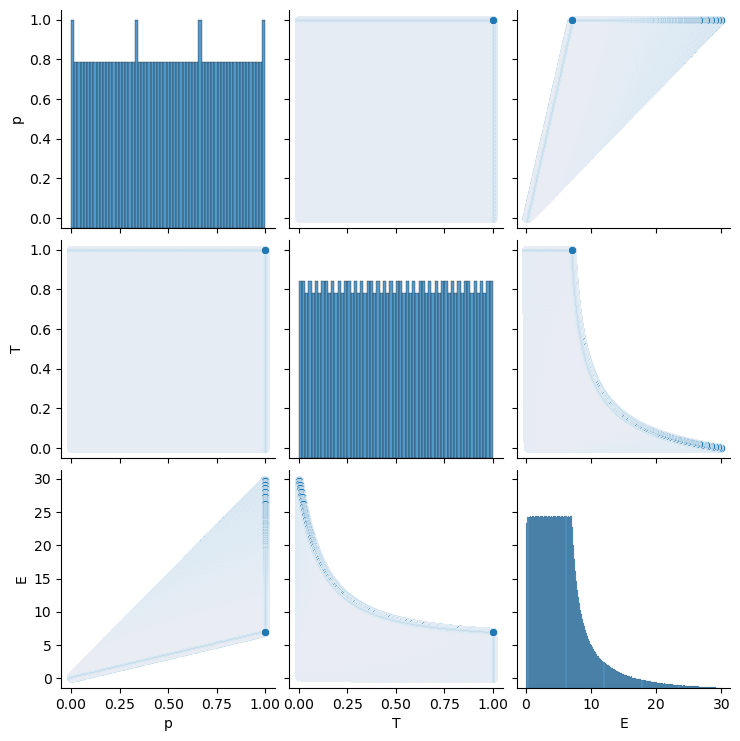

In [16]:
import seaborn as sns

all_data = df_X.copy()
all_data['E'] = df_y['E']
sns.pairplot(all_data)

In [86]:
df_X.corr()

,p,T
p,1.000000e+00,-1.011668e-15
T,-1.011668e-15,1.000000e+00


Корреляции между признаками нет.

___________________________________________
Подготавливаем данные для включения их в модели МО:

In [3]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_X[['p', 'T']] = scaler.fit_transform(df_X[['p', 'T']])

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.01, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.01, random_state=42)

print(f'Train, validation, test lengths = {X_train.shape[0]}, {X_valid.shape[0]}, {X_test.shape[0]}')

Train, validation, test lengths = 857587, 8576, 87


# FNN Regression

In [5]:
from torch.utils.data import Dataset, DataLoader

class Energy(Dataset):
    def __init__(self, X, y=None):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X.index)
    
    def __getitem__(self, index):
        x = self.X.iloc[index, ].values
        x = torch.tensor(x)
        x = x.to(torch.float32)
            
        if self.y is not None:
            output = torch.tensor(self.y.iloc[index])
            output = output.to(torch.float32)
            return x, output
        else:
            return x

train_dataset = Energy(X=X_train, y=y_train)
valid_dataset = Energy(X=X_valid, y=y_valid)
test_dataset = Energy(X=X_test)

train_loader = DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=256, shuffle=False)

In [6]:
import torch
import torch.nn as nn

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
#             nn.Dropout(0.2),
            nn.Linear(50, 1)
        )
        
    def forward(self, x):
        x = self.layers(x)
        return x

model = NN()
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

NN(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Tanh()
    (2): Linear(in_features=50, out_features=1, bias=True)
  )
)


In [7]:
mean_train_losses = []
mean_valid_losses = []
valid_acc_list = []

epochs = 20

for epoch in range(epochs):
    model.train()
    train_losses = []
    valid_losses = []
    for i, (xs, output) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(xs)

        loss = loss_fn(outputs, output)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())

            
    model.eval()

    with torch.no_grad():
        for i, (xs, output) in enumerate(valid_loader):
            outputs = model(xs)
            loss = loss_fn(outputs, output)
            valid_losses.append(loss.item())
               
    mean_train_losses.append(np.mean(train_losses))
    mean_valid_losses.append(np.mean(valid_losses))
    
    print('epoch : {}, train loss : {:.6f}, valid loss : {:.6f}'.format(epoch+1, np.mean(train_losses), np.mean(valid_losses)))

epoch : 1, train loss : 47236298.875224, valid loss : 46146157.058824


KeyboardInterrupt: 

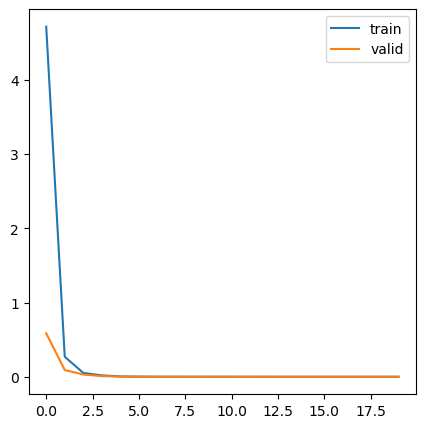

In [120]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

tocrop = 0
ax1.plot(mean_train_losses[tocrop:], label='train')
ax1.plot(mean_valid_losses[tocrop:], label='valid')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='best')
plt.show()

In [128]:
for name, param in model.named_parameters():
    print(name, param)

layers.0.weight Parameter containing:
tensor([[ 1.2889e+00,  1.9163e+00],
        [ 4.4718e-01, -4.2797e-02],
        [ 7.2290e-01, -1.1099e-01],
        [-3.2180e-01, -4.7303e-02],
        [-3.2721e-01, -8.5913e-02],
        [-1.2741e+00,  6.3138e-01],
        [ 8.6473e-01, -6.5277e+00],
        [ 9.6622e-01, -9.1249e+00],
        [ 9.0832e-01, -4.2232e+00],
        [-8.5891e-01, -4.5452e+00],
        [-3.5021e-01, -2.1410e-02],
        [-4.4292e-01,  3.4037e+00],
        [-4.4420e-01,  1.4092e-02],
        [ 6.4605e-01, -7.1452e-02],
        [-9.5830e-01,  8.2086e+00],
        [-1.0610e+00,  5.4322e+00],
        [ 7.7801e-01,  3.7712e+00],
        [ 8.9234e-01, -6.2321e+00],
        [-1.4594e+00,  2.4299e+01],
        [-6.4132e-01, -2.7187e-01],
        [ 4.7582e-01, -1.4492e-02],
        [-1.1913e+00, -3.9290e+00],
        [-8.8444e-01,  9.1841e+00],
        [-3.0511e-01, -6.5349e-02],
        [-2.2127e-01, -1.1942e-01],
        [-9.7478e-01, -5.2374e+00],
        [ 6.0510e-01, -2.5

In [129]:
toreshape = np.array([[ 1.2889e+00,  1.9163e+00],
        [ 4.4718e-01, -4.2797e-02],
        [ 7.2290e-01, -1.1099e-01],
        [-3.2180e-01, -4.7303e-02],
        [-3.2721e-01, -8.5913e-02],
        [-1.2741e+00,  6.3138e-01],
        [ 8.6473e-01, -6.5277e+00],
        [ 9.6622e-01, -9.1249e+00],
        [ 9.0832e-01, -4.2232e+00],
        [-8.5891e-01, -4.5452e+00],
        [-3.5021e-01, -2.1410e-02],
        [-4.4292e-01,  3.4037e+00],
        [-4.4420e-01,  1.4092e-02],
        [ 6.4605e-01, -7.1452e-02],
        [-9.5830e-01,  8.2086e+00],
        [-1.0610e+00,  5.4322e+00],
        [ 7.7801e-01,  3.7712e+00],
        [ 8.9234e-01, -6.2321e+00],
        [-1.4594e+00,  2.4299e+01],
        [-6.4132e-01, -2.7187e-01],
        [ 4.7582e-01, -1.4492e-02],
        [-1.1913e+00, -3.9290e+00],
        [-8.8444e-01,  9.1841e+00],
        [-3.0511e-01, -6.5349e-02],
        [-2.2127e-01, -1.1942e-01],
        [-9.7478e-01, -5.2374e+00],
        [ 6.0510e-01, -2.5597e-02],
        [ 1.3980e-01,  1.6332e-01],
        [ 6.8469e-01,  3.0894e+00],
        [-1.1611e+00, -6.3553e+00],
        [ 1.6291e-01,  1.4707e-01],
        [-5.9718e-01,  4.0162e-02],
        [-1.6766e-01, -1.4293e-01],
        [-9.8992e-01,  1.1032e+01],
        [-1.5763e+00, -9.8250e+00],
        [ 1.8676e-01,  1.5529e-01],
        [ 4.1663e-01, -2.7605e-02],
        [-4.8451e-01,  2.3876e+00],
        [-6.5565e-01, -1.2967e+00],
        [-2.2668e+00, -1.8458e+01],
        [-1.0259e+00, -4.2243e+00],
        [-3.8908e-01, -4.2004e-03],
        [-3.3784e-01, -2.8998e-02],
        [-2.7497e-01, -6.4331e-02],
        [-3.2440e-01, -4.3833e-02],
        [ 1.1114e+00, -2.2930e+00],
        [ 9.5687e-01, -3.5966e-01],
        [ 6.5317e-01,  1.8460e+00],
        [ 4.0937e-01,  3.7000e-03],
        [-2.0332e-01, -1.3942e-01]])
np.swapaxes(toreshape,0,1)

array([[ 1.2889e+00,  4.4718e-01,  7.2290e-01, -3.2180e-01, -3.2721e-01,
        -1.2741e+00,  8.6473e-01,  9.6622e-01,  9.0832e-01, -8.5891e-01,
        -3.5021e-01, -4.4292e-01, -4.4420e-01,  6.4605e-01, -9.5830e-01,
        -1.0610e+00,  7.7801e-01,  8.9234e-01, -1.4594e+00, -6.4132e-01,
         4.7582e-01, -1.1913e+00, -8.8444e-01, -3.0511e-01, -2.2127e-01,
        -9.7478e-01,  6.0510e-01,  1.3980e-01,  6.8469e-01, -1.1611e+00,
         1.6291e-01, -5.9718e-01, -1.6766e-01, -9.8992e-01, -1.5763e+00,
         1.8676e-01,  4.1663e-01, -4.8451e-01, -6.5565e-01, -2.2668e+00,
        -1.0259e+00, -3.8908e-01, -3.3784e-01, -2.7497e-01, -3.2440e-01,
         1.1114e+00,  9.5687e-01,  6.5317e-01,  4.0937e-01, -2.0332e-01],
       [ 1.9163e+00, -4.2797e-02, -1.1099e-01, -4.7303e-02, -8.5913e-02,
         6.3138e-01, -6.5277e+00, -9.1249e+00, -4.2232e+00, -4.5452e+00,
        -2.1410e-02,  3.4037e+00,  1.4092e-02, -7.1452e-02,  8.2086e+00,
         5.4322e+00,  3.7712e+00, -6.2321e+00,  2.

In [123]:
# for child in model.named_children():
#     print(child)
#     layer_name = child[0]
#     layer_params = {}
#     for param in child[1].named_parameters():
#         print(param)
#         param_name = param[0]
#         param_value = param[1].data.numpy()
#         layer_params[param_name] = param_value
    
#     # Save here using your syntax. E.g.
#     save_name = layer_name + '.npy'
#     np.save(save_name, layer_params)

In [130]:
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as rmse
import time

rmses, mapes, times = [], [], []
for i in range(len(X_valid)):
    y_true = y_valid.reset_index(drop=True).iloc[i]
    x = X_valid.reset_index(drop=True).iloc[i]
    input_value = torch.tensor([x]).to(torch.float32)
    t0 = time.time()
    predicted_value = model(input_value)
    times.append(time.time() - t0)
    print(float(y_true), float(predicted_value))
    mapes.append(100*mape([y_true], [float(predicted_value)]))
    rmses.append(rmse([y_true], [float(predicted_value)], squared=False))

print(f"TIME={np.mean(times)}, (speed up = {default_time/np.mean(times)}), RMSE={np.mean(rmses)}, MAPE={np.mean(mapes)}")

10.742656670513202 10.747421264648438
19.932312452359554 19.935333251953125
20.782024321626405 20.785228729248047
9.7617074553269 9.764342308044434
2.7535463331910988 2.7568912506103516
1.938549550326554 1.9477585554122925
9.2433025809542 9.2445707321167
3.6222805978111765 3.6271934509277344
9.367762589660147 9.368443489074707
17.524974761426012 17.531644821166992
5.605014146533819 5.611606597900391
3.7384904568595183 3.743961811065674
4.894123895284233 4.897736549377441
6.3687314367976855 6.367530345916748
4.913767267041871 4.916536331176758
6.683208804753998 6.686587810516357
4.187827287935285 4.192307949066162
9.050549808860387 9.056729316711426
3.811132070108335 3.8121328353881836
0.7240369022637357 0.7254503965377808
3.38680364529459 3.3912339210510254
2.8789674782308143 2.8792333602905273
5.533572152922601 5.538891315460205
2.4488262881821923 2.450723648071289
1.6646855690521971 1.668357491493225
5.244160753850217 5.247470855712891
12.506379377378781 12.512321472167969
4.19083956

3.2665835583079135 3.2742505073547363
4.592854746968278 4.598570823669434
8.552639449759356 8.550718307495117
6.459203955748466 6.459641456604004
8.382326645965584 8.388434410095215
1.8390386597912656 1.847537636756897
1.2328290422482178 1.236075758934021
7.773010484989756 7.774935245513916
6.044733986773733 6.0508527755737305
10.580391256011605 10.58368968963623
2.8302686054859656 2.8313026428222656
0.3017767311861347 0.29705655574798584
4.340157604408061 4.342772960662842
3.028074535455214 3.0291481018066406
6.673107229142143 6.678437232971191
3.9992666008182547 4.003132343292236
5.401908573396063 5.40324592590332
10.635693886378233 10.64095687866211
0.6320946664211297 0.6334880590438843
8.556895244547096 8.562965393066406
3.8396490693941856 3.8425631523132324
6.133791114978203 6.136445999145508
1.9015746923175225 1.9044054746627808
11.124232002978449 11.126391410827637
1.7999792165499438 1.8034127950668335
2.7355885962646647 2.743856906890869
2.102128344023101 2.104422092437744
11.2

5.943715028061096 5.950157165527344
7.140663333103748 7.144802093505859
3.872807765077263 3.874107837677002
4.8459883864532305 4.8451032638549805
6.111634078933066 6.112685680389404
7.996770492305957 7.996356010437012
1.4975002618838142 1.50011146068573
5.215754261695391 5.2204132080078125
7.456401651294448 7.455207824707031
6.5839546830138085 6.58651065826416
0.5549984473070156 0.5593050718307495
6.384815546382307 6.389959335327148
10.836765455916133 10.839926719665527
5.536141984685762 5.53606653213501
8.560095092412057 8.559268951416016
16.480308427976027 16.48759651184082
5.933439545718997 5.937376499176025
14.570518950633263 14.574204444885254
8.219521679563204 8.223408699035645
6.397612981781312 6.402923107147217
11.314727769209018 11.321064949035645
4.890792748641024 4.896867275238037
0.8477468663151683 0.8519266843795776
3.706075107798052 3.7048120498657227
3.523680308614692 3.5318493843078613
6.610733764869658 6.616955280303955
5.938845338664354 5.9470109939575195
9.9222473085

4.996991197045442 4.999755382537842
2.975535284570222 2.9777565002441406
0.3099046857905526 0.31043708324432373
4.442859976644649 4.444030284881592
2.903842025222144 2.904130458831787
14.930156532644505 14.934928894042969
16.343988313064997 16.351713180541992
12.50030226037789 12.504404067993164
0.23382954812774046 0.22825992107391357
2.854025266369854 2.855635643005371
2.6244454598689693 2.6289854049682617
0.812494011264747 0.8137801885604858
4.915788442326252 4.918509006500244
2.664439074632835 2.665727138519287
2.9076752140004025 2.9079360961914062
1.0917618774925493 1.0959566831588745
6.62703113187236 6.6294660568237305
0.45045207357017625 0.4550060033798218
3.1202075627926362 3.129389762878418
8.182800437995008 8.18964958190918
0.6091051682882372 0.6135753393173218
6.628148204591784 6.62818717956543
2.660603370227829 2.6601672172546387
7.377118062416472 7.376733779907227
0.7921522110506483 0.7937554121017456
1.373551102541562 1.377118706703186
21.010128367703985 21.012210845947266

0.9667631051987255 0.9694861173629761
1.556511730888428 1.560031533241272
2.8670347851292743 2.8766398429870605
9.016274016318302 9.019944190979004
8.668040887965093 8.673385620117188
2.2035612556197584 2.2060189247131348
4.408028594778931 4.406704425811768
4.3795958569931415 4.380094051361084
3.494251502581608 3.4948577880859375
3.4584206287333177 3.4620156288146973
7.078498630563358 7.084809303283691
5.694527233438589 5.700220584869385
8.426354223026037 8.43307876586914
18.057415615536403 18.062625885009766
4.741484528841727 4.740812301635742
0.32428113003181125 0.3275226354598999
3.2530856837413804 3.2516374588012695
1.0856303826573854 1.0890535116195679
4.776698970172526 4.778596878051758
7.674862503373398 7.681604862213135
5.250460055675759 5.255169868469238
2.1507939355262176 2.1530909538269043
13.735749700809968 13.73851203918457
2.410511822507609 2.4157609939575195
8.47550559685338 8.47970962524414
1.9187395773289804 1.9247442483901978
13.690978075539904 13.698049545288086
14.1

8.793976339826008 8.795167922973633
3.011079430132792 3.0175600051879883
4.66869348390767 4.668328762054443
13.935766103426792 13.942917823791504
7.574846291395588 7.580837726593018
4.998298619557741 5.004960060119629
5.6759130341591755 5.676867485046387
11.072160207264588 11.079410552978516
1.5053705625789937 1.5087755918502808
3.875156158613554 3.8804707527160645
3.2732617950589638 3.281982421875
0.3759497437628289 0.3764909505844116
0.7852697192214462 0.7890805006027222
2.3442246409798435 2.3497586250305176
7.5753727809704925 7.580551624298096
2.046773495510162 2.0498361587524414
8.74018035604053 8.740303039550781
0.7480825789285098 0.7495373487472534
5.811934428557997 5.816430568695068
3.103449651582962 3.1107516288757324
2.258051304980058 2.265130043029785
5.457785472870433 5.464720249176025
6.125112626711713 6.127765655517578
4.281502663279389 4.286213397979736
5.037645253264996 5.041494369506836
0.8143044507647021 0.8187583684921265
1.7482240079782898 1.7553914785385132
11.68176

10.503383399538553 10.506208419799805
0.9926262178248145 0.9952515363693237
4.12929436534522 4.1349287033081055
3.226647559568691 3.2261133193969727
5.018117190218683 5.020621299743652
1.640046151646993 1.6476227045059204
5.006534961164388 5.007944107055664
3.094721790759935 3.096088409423828
2.9476494873281904 2.9477458000183105
3.557847206957396 3.562798023223877
9.32672838589329 9.332715034484863
5.383287432108387 5.389996528625488
7.277653093716442 7.278061389923096
9.838652616888504 9.841569900512695
6.652580994484119 6.656087875366211
13.905181457819378 13.912461280822754
11.209831445483694 11.215283393859863
5.611262617937427 5.614360809326172
1.614828331087649 1.6181155443191528
5.31200734561207 5.3195319175720215
9.386287463374007 9.386757850646973
2.644194830395492 2.645913600921631
3.5379025089833016 3.5404162406921387
14.494286827654577 14.493398666381836
4.753565496649558 4.75697135925293
26.90537270842947 26.902584075927734
2.275275826756145 2.2798614501953125
0.450571064

5.930515970962983 5.9299774169921875
5.922564105178151 5.924965858459473
8.538469722411017 8.543868064880371
10.674038791055832 10.677358627319336
3.278297170619356 3.2810921669006348
2.508655436988115 2.518606185913086
1.7114670603646878 1.71456778049469
7.432753516361251 7.427241802215576
3.4582527943604364 3.4584450721740723
4.065211064019089 4.069213390350342
0.6270785181936285 0.6286972761154175
2.8263049399180473 2.8360085487365723
2.7124148194156055 2.7125182151794434
9.89042193748362 9.897000312805176
0.7064530711320345 0.706757664680481
6.613041601956384 6.617837429046631
2.5586999080410435 2.5570225715637207
7.295874943617143 7.295775413513184
1.5926841126233586 1.5959841012954712
2.1934316488590144 2.1962928771972656
0.7900455032464736 0.7924565076828003
3.7724509095764986 3.775843620300293
14.315953804001737 14.321521759033203
1.6595171609058985 1.6596506834030151
1.6082713615202557 1.612963080406189
0.9714560680427853 0.9744018316268921
24.783097634150714 24.79749488830566

4.686531539432995 4.688240051269531
0.4224391899865234 0.41746366024017334
7.917812502419624 7.924593925476074
2.364199639535211 2.362644672393799
1.519601535694462 1.522924542427063
11.279132858318606 11.282087326049805
1.9321575007899987 1.9340420961380005
9.310016684012442 9.310332298278809
1.9682985686952352 1.9714699983596802
2.794795473942053 2.7960734367370605
13.757723193782727 13.756701469421387
0.907081003201886 0.9102333784103394
9.610002560122405 9.616470336914062
6.815530777292751 6.816378593444824
4.216608556174045 4.221155166625977
6.953634107758462 6.959990978240967
3.0427658759781187 3.0473203659057617
2.600184744595235 2.6040797233581543
6.511208161479151 6.5161943435668945
5.711215885168821 5.71157169342041
4.138281487993653 4.138640403747559
5.3837440270818755 5.384665489196777
3.9553091988221603 3.9582061767578125
11.189319126143085 11.19267463684082
5.243351346429609 5.249987602233887
1.3601509988027416 1.3649712800979614
6.500398146591149 6.499919891357422
11.082

4.19728832901455 4.201790809631348
2.8387271531936054 2.84389066696167
0.13777583466533694 0.13024699687957764
0.44865249354642944 0.44541895389556885
8.084969765834078 8.091793060302734
4.106753517354261 4.106148719787598
3.9432473124064953 3.947038173675537
1.5923771584233275 1.5985654592514038
1.7553351205876075 1.7634037733078003
7.723343082610758 7.725538730621338
9.501853932058937 9.506441116333008
0.1228175821032185 0.12549293041229248
6.885233582496448 6.883094310760498
1.990623525805515 1.9946690797805786
5.902270092936666 5.910363674163818
1.7880959085163772 1.7907434701919556
2.1834920915069396 2.185664176940918
6.207354745254033 6.214998722076416
7.089782039669733 7.094177722930908
6.752973271667318 6.75778865814209
1.955447649786044 1.9590319395065308
4.596018273884162 4.60027551651001
2.7998204561902416 2.809084415435791
2.228384989399725 2.2243523597717285
3.007034394483843 3.0163955688476562
4.2242944751281994 4.226277828216553
2.026231388841601 2.0297179222106934
7.905

4.05001414741394 4.053360939025879
2.332494008233421 2.3341903686523438
1.803506215808536 1.8069876432418823
6.089853640990903 6.092897891998291
3.9407533223560867 3.9427337646484375
10.365974266935016 10.368263244628906
1.4737943211192444 1.4753769636154175
8.9311451789362 8.935222625732422
0.4041179630612157 0.4053443670272827
15.584096634941512 15.589874267578125
2.998041778855027 2.997807025909424
9.526793072118108 9.533100128173828
7.983016404766866 7.9893598556518555
4.016859377706028 4.023172378540039
5.492673820987175 5.493049144744873
6.079171215619835 6.081747055053711
3.7806459571773834 3.781604290008545
6.634328299856517 6.636373519897461
4.7266966947607205 4.727856636047363
5.217941218801361 5.218434810638428
5.241814643369691 5.246918201446533
7.0756368703840415 7.081906318664551
1.5437214062617133 1.5505086183547974
0.17385037652696336 0.17492949962615967
4.1169529719559215 4.120273113250732
0.8963466011563385 0.8989790678024292
8.38532842260129 8.391082763671875
6.96183

27.666135983025338 27.654403686523438
8.147280367539723 8.14957046508789
11.715360260974524 11.716497421264648
12.021228643179697 12.027170181274414
5.508874156306606 5.516729831695557
9.1993316534275 9.199142456054688
4.417480939978364 4.417113780975342
5.936666487202193 5.944040298461914
3.637990470499521 3.6374306678771973
9.573537966513308 9.579627990722656
2.2617463247257694 2.2637290954589844
5.826121941186162 5.8330607414245605
6.533805579412606 6.539728164672852
6.79666600166284 6.802068710327148
6.217325063785387 6.2250823974609375
5.806900911483939 5.813765525817871
10.32044502153906 10.324711799621582
11.327369569701409 11.330705642700195
5.790099636596997 5.793659687042236
4.91762058587231 4.922819137573242
0.8519051110525888 0.855239748954773
5.620844691477275 5.623690605163574
1.2344953851961318 1.2361668348312378
15.307780454812324 15.310513496398926
4.455065512628543 4.453427314758301
9.747287361180456 9.753767967224121
5.9605960091561485 5.9677042961120605
8.5300503345

0.46734986974685166 0.46523940563201904
3.792510637545023 3.7954225540161133
6.591362792789968 6.592452526092529
0.8175775195272651 0.81908118724823
8.685353887475022 8.690147399902344
4.505784773910368 4.507973670959473
7.925282769620976 7.931759834289551
7.477918438828381 7.484099388122559
7.259220975097225 7.260369777679443
11.641612395702682 11.645882606506348
2.0393009939647038 2.041989326477051
4.601470195568484 4.60551643371582
5.0958463290713185 5.100391387939453
7.019516564503142 7.011266231536865
4.7038644156529195 4.702370643615723
3.1105697346795216 3.111563205718994
9.042911950895192 9.04689884185791
5.869838001025917 5.87260627746582
6.703234362849588 6.704441070556641
2.4445708290853987 2.4459409713745117
3.1452489925829736 3.151186943054199
2.4526593505229504 2.45682954788208
4.2920685159293654 4.292820453643799
1.8392695882991188 1.8428350687026978
6.4266930407894085 6.431782245635986
11.652771841512857 11.656915664672852
6.423834629456994 6.431211948394775
0.631068705

1.7255064567531053 1.7292009592056274
2.398678361066489 2.407784938812256
2.126190288916049 2.126856803894043
11.200817615221952 11.2020845413208
6.817683026361541 6.8181538581848145
2.044304220102832 2.0431275367736816
4.977880689419666 4.981856346130371
3.4470499652915376 3.446263313293457
6.045008306828518 6.048769474029541
2.374081495245618 2.3766841888427734
6.573971725362734 6.5763044357299805
5.6118369923140365 5.613690376281738
20.551522992866673 20.554569244384766
3.727993404836327 3.7298760414123535
25.060455806039535 25.071453094482422
1.0739962899047673 1.0773485898971558
6.767678984158632 6.766164779663086
2.8305805471835015 2.8317575454711914
5.4041309964825315 5.408980369567871
6.074622246492776 6.082017421722412
2.3732347813007357 2.3772926330566406
5.482974874261469 5.483720302581787
0.3469720380440252 0.3429526090621948
7.457252762366749 7.463298797607422
0.5339469801565105 0.5346463918685913
1.9902003933876649 1.9913448095321655
8.187017831125031 8.193781852722168
6.

4.0644798111485345 4.071148872375488
7.140813660132955 7.145562648773193
1.0768540216116314 1.0815986394882202
1.425446316678337 1.4286214113235474
9.814014311424843 9.814974784851074
0.4172494838838079 0.4218481779098511
5.4348340157103 5.434547424316406
9.234448883247923 9.238685607910156
22.495171759973232 22.499361038208008
10.054800316025753 10.06060791015625
5.501927577212439 5.508731842041016
5.897022436916552 5.902348041534424
4.103703023075087 4.107401371002197
4.516649491177774 4.517901420593262
3.8554419490728087 3.858745574951172
5.415992594908853 5.4194016456604
2.519182600509437 2.524944305419922
0.4365806706176469 0.4397681951522827
2.416846527476431 2.4267759323120117
4.932656412817482 4.93565559387207
10.781553739033866 10.784341812133789
3.138744187042842 3.1478071212768555
6.045424230399425 6.049354553222656
12.214475821504193 12.218273162841797
2.040947319793849 2.0406932830810547
8.509915411217268 8.509055137634277
6.3811668746161665 6.387934684753418
1.38226275179

0.3092651725802213 0.30552709102630615
6.08467718997254 6.086042404174805
6.180085801486703 6.184093475341797
8.700881854267866 8.701231002807617
7.410694876402885 7.406985282897949
3.7240223741115037 3.7238821983337402
0.3401347855896313 0.3446544408798218
4.417131978251286 4.418320655822754
2.7144787364820497 2.715167999267578
2.3086929745110516 2.3107314109802246
7.698766349842038 7.703805923461914
6.524301320413482 6.527109146118164
1.604127524311957 1.6079953908920288
5.9475671362515365 5.951019763946533
0.7579670637077094 0.7602275609970093
5.324971857374941 5.326513290405273
4.193289599270214 4.197786331176758
1.9952427815339027 1.99581778049469
5.850656645500564 5.852957248687744
6.992068232899389 6.996854782104492
0.9494346576084396 0.9532450437545776
6.402663655924384 6.408288955688477
2.838816055692951 2.839230537414551
7.118071165468169 7.116701602935791
4.4350817613688 4.434426307678223
9.661209577302488 9.667855262756348
1.4811855182861153 1.4836839437484741
4.78599240093

1.6487540255318407 1.6524676084518433
4.110819350189643 4.113792419433594
0.5379409878531963 0.5391067266464233
5.248778551032253 5.251380920410156
2.1161146213877 2.1190128326416016
0.07729327806529838 0.07927596569061279
3.796962298132759 3.7962374687194824
2.8424143901816046 2.842902183532715
11.453712621548915 11.457183837890625
2.2884467128723993 2.2910895347595215
7.015018266449754 7.0168962478637695
15.245583381283552 15.244524002075195
4.414524791566422 4.417784690856934
3.637760430314798 3.6455883979797363
9.14222975080279 9.143338203430176
2.9236194862484255 2.9257359504699707
3.690767680340797 3.6909961700439453
4.7380807477726075 4.741204261779785
1.6245459060982521 1.631304383277893
1.2987573002718584 1.3025916814804077
1.5657961781774143 1.5694493055343628
1.8689504764769385 1.8750401735305786
2.1029473785020367 2.1056785583496094
5.19991894376869 5.201241970062256
4.055986200880731 4.055697441101074
7.033416943029622 7.037082195281982
6.374288199714603 6.374067306518555


1.4812845647851869 1.4848731756210327
2.003615570016821 2.006150245666504
7.879526017668358 7.885442733764648
5.491234323456749 5.491848945617676
6.673243425427955 6.67488956451416
1.6817508468179763 1.6851824522018433
6.421057349333525 6.425421237945557
4.791110096110073 4.792872428894043
7.637565403059502 7.644339561462402
5.757284923667061 5.758727073669434
5.659019363983233 5.658991813659668
2.3271860770454706 2.328491687774658
8.978362796190147 8.978178977966309
3.490553120203579 3.492727756500244
21.62324644155235 21.626806259155273
1.6041388628811621 1.6068724393844604
1.562700458127857 1.5666109323501587
5.464300332984592 5.4665985107421875
0.09876151325584188 0.09979236125946045
1.9852219364073758 1.9888523817062378
0.7556983552404787 0.7577217817306519
8.662827064515032 8.666829109191895
3.3511810839192893 3.35526180267334
4.639744977731353 4.638901710510254
6.761818899756335 6.761527061462402
7.993886288941883 7.999344348907471
3.7027806157413807 3.704120635986328
6.00735297

9.035378962679395 9.039450645446777
6.065329666695928 6.069572448730469
2.0795070177952257 2.084321975708008
2.5214112009459906 2.525423049926758
5.996190290943628 6.002450466156006
3.61226048011603 3.6185827255249023
4.59652950561632 4.601919174194336
4.4071834281570545 4.407841205596924
5.360927377861545 5.361212253570557
10.723975265743448 10.72498893737793
15.676728493270636 15.675518989562988
5.376407359815744 5.3760833740234375
7.206202950411885 7.205008506774902
4.609634067788644 4.612360954284668
4.605614615022078 4.609254360198975
6.678270639051748 6.682580471038818
3.1019013014730765 3.1094112396240234
8.049441195458096 8.054850578308105
5.757141047388095 5.758419990539551
4.29837280120012 4.3013997077941895
4.472565764977839 4.476938724517822
10.385865202337191 10.388486862182617
4.141715401715206 4.141834735870361
19.002137328695248 19.006919860839844
2.5523352344380186 2.554386615753174
2.308126525818934 2.3108181953430176
4.0994699524226625 4.098624229431152
5.96970502047

4.542982872279694 4.541412353515625
8.579001775358545 8.579097747802734
4.995789984508085 4.998766899108887
9.098665937479263 9.105012893676758
16.981488922902383 16.984176635742188
5.761188801864116 5.768355369567871
2.205900309521069 2.2015929222106934
5.772613344747074 5.7734503746032715
2.4117450607512265 2.4156603813171387
2.194479540278026 2.196725845336914
6.495824976484174 6.502980709075928
5.237504565266593 5.244502067565918
2.644285413273429 2.6451611518859863
4.366416079998333 4.370293140411377
6.465107261162504 6.46651029586792
7.999532352467778 8.006429672241211
1.6118222550435208 1.6150497198104858
9.047231492842984 9.053686141967773
5.770580937419668 5.773499488830566
2.5406482624654063 2.5504493713378906
14.944207613979076 14.95118522644043
10.52121099314453 10.527852058410645
5.455360711853027 5.461315155029297
23.21157850392142 23.21596336364746
2.9062272552552195 2.907470226287842
18.605396170914563 18.609758377075195
0.32996397941642386 0.32638537883758545
1.9458301

4.043776343847625 4.047980785369873
8.705890697360253 8.710247993469238
3.9437983840897117 3.9453511238098145
0.4242361048927345 0.42155635356903076
8.046523584545687 8.053384780883789
4.986806795670154 4.985997200012207
1.0845445268876202 1.0873922109603882
5.427616190962959 5.432645320892334
6.503213787473552 6.500295639038086
3.973609062462432 3.972726345062256
28.549749537057608 28.546527862548828
2.9520585301627906 2.960878372192383
8.35080938876528 8.349444389343262
1.275508412434411 1.2811723947525024
0.1928498460891294 0.18632400035858154
0.08567286958326852 0.08836162090301514
9.01224423492549 9.015655517578125
5.370436872115014 5.378167152404785
3.846172589530389 3.8495755195617676
0.7605078396369812 0.7618411779403687
3.3237937174022103 3.3250937461853027
5.389770761908137 5.39199161529541
3.4937535585007833 3.5020055770874023
0.38683841868689833 0.389795184135437
11.421543360246721 11.421831130981445
12.344915444714687 12.352402687072754
2.9109908899976946 2.920474052429199

10.723766340343932 10.729604721069336
1.6308068778732603 1.6379855871200562
8.885506997710936 8.89161491394043
7.323733709606327 7.326056003570557
3.748562210251271 3.755873203277588
1.9816562947133893 1.9851394891738892
4.624931577389897 4.62404727935791
3.160581856278257 3.1605496406555176
1.2124602998746306 1.2153195142745972
12.794190704560032 12.793882369995117
14.706202833494782 14.705506324768066
7.855904619239144 7.855700492858887
2.034356517875665 2.043910503387451
1.9400885908046268 1.943031668663025
11.666430861244342 11.670391082763672
5.696784696348351 5.697458267211914
7.763643103617722 7.762019157409668
5.676114869675945 5.67732572555542
2.3863795316330014 2.3889894485473633
7.571269406112038 7.575710296630859
0.18556545746556485 0.18819987773895264
17.479146987633982 17.476341247558594
6.295952874111616 6.29885196685791
2.7834039995848974 2.784209728240967
7.218839551057725 7.223187446594238
1.3282893753907945 1.3316301107406616
18.406784849374656 18.41246795654297
3.42

20.161429980393642 20.164506912231445
2.8498457827934933 2.8519158363342285
4.971223305651896 4.970755100250244
3.5476474002280534 3.5500288009643555
2.5563805824609966 2.565934658050537
5.380115204950081 5.380614757537842
0.4708668972262511 0.4679344892501831
2.9397082355000115 2.940645694732666
0.768266422978999 0.7707871198654175
3.826353464897221 3.829653739929199
3.861337122277349 3.86378812789917
1.4484609354349518 1.4471880197525024
0.9437624636373122 0.9459398984909058
6.6235706107743475 6.630413055419922
2.4115502756373095 2.4136295318603516
15.085768540586535 15.087590217590332
2.410427384271906 2.415475368499756
2.3019005742799044 2.3041815757751465
5.5995222867012115 5.604578971862793
0.11883004075972715 0.12291991710662842
11.454587437386017 11.461775779724121
11.47957908991835 11.48379898071289
0.19936825460799507 0.2017139196395874
4.410283007222029 4.412880897521973
8.466790767933622 8.47228717803955
1.374602527353437 1.3774584531784058
4.065769133153989 4.0700774192810

10.534326477167117 10.536465644836426
3.585398384242895 3.5925087928771973
2.240382088122754 2.240142345428467
15.330356314411022 15.328960418701172
0.7746418171984544 0.7762640714645386
4.4841616656624925 4.488337993621826
6.335560272423249 6.339604377746582
16.023798577266565 16.028104782104492
4.976580077524703 4.9762091636657715
1.604628785079258 1.6082998514175415
5.980836184474744 5.987248420715332
5.080931657771369 5.08392333984375
7.025006570862398 7.031376838684082
5.628393517170383 5.629372596740723
7.366390382808428 7.368921279907227
2.02929227817733 2.032062530517578
0.16023589919959566 0.1642974615097046
3.4991355154747255 3.505690574645996
2.9209043462162905 2.9250807762145996
5.398229811778129 5.400409698486328
7.325024159896802 7.330033779144287
4.647786289816183 4.649889945983887
2.8099690033880194 2.81427001953125
11.717823211330156 11.723043441772461
1.948617995539052 1.956119418144226
5.066741557864474 5.07301664352417
0.9900864416095768 0.9844735860824585
2.2072781

4.95897980651093 4.9612627029418945
0.8195361501170898 0.8216980695724487
5.809816359586633 5.811800003051758
1.4696252355506103 1.473706841468811
0.6295212903877824 0.6329210996627808
9.912700044569407 9.916604995727539
0.13987104945666878 0.13491857051849365
6.886376251756188 6.888600826263428
0.7646377882460715 0.7657698392868042
0.8611618104997906 0.8641284704208374
1.1741074882057052 1.1743210554122925
5.92913001331329 5.928496360778809
1.1288319534716593 1.1315256357192993
6.526049275128675 6.52577018737793
3.9179786353265684 3.9237399101257324
2.788303786576135 2.789759635925293
3.7725301760270873 3.7710561752319336
6.1646837792477855 6.169714450836182
13.145633149468964 13.144981384277344
15.588789486824307 15.583260536193848
1.7937903481741382 1.7969778776168823
5.919889123308878 5.927128791809082
9.803010922617368 9.806403160095215
2.577422492635449 2.5790839195251465
8.56282174585071 8.567717552185059
3.0269279054007723 3.0269079208374023
5.318373874371366 5.31784725189209
2

13.658308832352686 13.66408920288086
2.621413497533561 2.628408908843994
0.8467452785915044 0.8402279615402222
2.835110442397664 2.8363871574401855
17.568792427432157 17.57228660583496
6.956476979611139 6.958523750305176
11.0816906140847 11.085047721862793
2.207235535742465 2.211256980895996
9.061113277338277 9.06755256652832
1.4994335518546955 1.50686514377594
3.386518656349157 3.385870933532715
4.888143884504913 4.89471435546875
1.898515723338157 1.902030348777771
7.067382146186475 7.067996025085449
3.531888607521921 3.5307297706604004
0.2686608282943314 0.26469695568084717
3.4690776120769486 3.4681015014648438
3.9272679299780924 3.9306139945983887
9.309441813469437 9.308615684509277
6.212925378634508 6.218923568725586
8.636992153785425 8.643221855163574
7.3427705370105185 7.349203109741211
1.7889909747285744 1.7924991846084595
2.816079181657366 2.817479133605957
11.42612589070316 11.429086685180664
5.174212749736616 5.176957130432129
2.4747277701157193 2.4766697883605957
1.734382624

8.65663426671598 8.656318664550781
4.444771956472564 4.445860862731934
14.800285279153767 14.801078796386719
7.447324677576287 7.444097518920898
5.711134155459596 5.7137556076049805
6.116961575509609 6.124001502990723
6.585316092116068 6.583460807800293
2.9686420901543555 2.9686789512634277
2.620961813433159 2.6298513412475586
7.498830146110622 7.50241231918335
8.426742956047676 8.43311882019043
0.97483880174693 0.9773262739181519
21.901064479045754 21.90593147277832
7.456642631516876 7.463183403015137
11.902378100630374 11.90717887878418
6.487337999183445 6.493959426879883
16.19204479502843 16.193130493164062
1.2820814907052567 1.2865058183670044
2.6491560334757316 2.6589555740356445
5.916994182420121 5.916440010070801
0.8657741601472535 0.8678101301193237
5.713270096164435 5.713585376739502
8.799144612465119 8.798454284667969
12.772849185897863 12.773832321166992
3.486782946113623 3.4870028495788574
4.014813402157549 4.016374588012695
7.8535608419276395 7.860447406768799
5.2458017859

In [13]:
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as rmse
import time

rmses, mapes, times = [], [], []
for i in range(len(X_test)):
    y_true = y_test.reset_index(drop=True).iloc[i]
    x = X_test.reset_index(drop=True).iloc[i]
    input_value = torch.tensor([x]).to(torch.float32)
    t0 = time.time()
    predicted_value = model(input_value)
    times.append(time.time() - t0)
    #print(float(y_true), float(predicted_value))
    mapes.append(100*mape([y_true], [float(predicted_value)]))
    rmses.append(rmse([y_true], [float(predicted_value)], squared=False))

print(f"TIME={np.mean(times)}, (speed up = {default_time/np.mean(times)}), RMSE={np.mean(rmses)}, MAPE={np.mean(mapes)}")

TIME=7.454439791666198e-05, (speed up = 254.07923842417313), RMSE=0.016715497816293102, MAPE=0.6308851862359723


Сохраним обученную pytorch модель:

In [14]:
from random import randrange
x = X_test.reset_index(drop=True).iloc[randrange(len(X_test))]
example = torch.tensor([x]).to(torch.float32)
traced_model = torch.jit.trace(model, example)

In [16]:
traced_model.save("traced_energynn_model.pt")

# k-NN Regression

In [76]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': [2, 3, 4, 5, 6, 10]}
model_class = KNeighborsRegressor()
grid_search = GridSearchCV(estimator=model_class, param_grid=param_grid, cv=5, verbose=True)
grid_search.fit(X_train, y_train)
grid_search.best_estimator_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


KNeighborsRegressor(n_neighbors=6)

In [77]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as rmse
import timeit

kNNmodel = KNeighborsRegressor(n_neighbors=6)
kNNmodel.fit(X_train, y_train)

predictions, mapes, rmses, times = [], [], [], []
for i in range(len(X_test)):
    
    x = X_test.reset_index(drop=True).iloc[i]
    start_time = time.time()
    prediction = kNNmodel.predict([x])[0]
    times.append(time.time() - start_time)
    predictions.append(prediction)
    
    y_true = y_test.reset_index(drop=True).iloc[i]
    mapes.append(100*mape([y_true], [prediction]))
    rmses.append(rmse([y_true], [prediction], squared=False))

print(f"TIME={np.mean(times)}, (speed up = {default_time/np.mean(times)}, RMSE={np.mean(rmses)}, MAPE={np.mean(mapes)}")

TIME=0.00032735796568031134, (speed up = 52.70934547961547, RMSE=0.006288471970733609, MAPE=0.22802597964260068


# DT Regression

In [58]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_features': ['auto'],
              'max_depth' : [3, 5, 10],
              'min_samples_leaf': [2, 3, 4, 5, 6, 10]
             }
tree_clas = DecisionTreeRegressor()
grid_search = GridSearchCV(estimator=tree_clas, param_grid=param_grid, cv=5, verbose=True)
grid_search.fit(X_train, y_train)
grid_search.best_estimator_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


DecisionTreeRegressor(max_depth=10, max_features='auto', min_samples_leaf=2)

In [59]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as rmse
import timeit

DTmodel = DecisionTreeRegressor(
        max_depth=10,
        max_features='auto',
        min_samples_leaf=2,
#         min_weight_fraction_leaf=0.1,
        splitter='random'
    )
DTmodel.fit(X_train, y_train)

predictions, mapes, rmses, times = [], [], [], []
for i in range(len(X_test)):
    
    x = X_test.reset_index(drop=True).iloc[i]
    start_time = timeit.default_timer()
    prediction = DTmodel.predict([x])[0]
    times.append(timeit.default_timer() - start_time)
    predictions.append(prediction)
    
    y_true = y_test.reset_index(drop=True).iloc[i]
    mapes.append(100*mape([y_true], [prediction]))
    rmses.append(rmse([y_true], [prediction], squared=False))

print(f"TIME={np.mean(times)}, (speed up = {default_time/np.mean(times)}, RMSE={np.mean(rmses)}, MAPE={np.mean(mapes)}")

TIME=7.876553003546677e-05, (speed up = 219.06567632793283, RMSE=0.38988933363952016, MAPE=7.423288909677051


# RF Regression

In [60]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as rmse
import timeit

RFModel = RandomForestRegressor(
    max_depth=10, 
    min_samples_leaf=2, 
    n_estimators=10,
    n_jobs=-1
    )
RFModel.fit(X_train, y_train)

predictions, mapes, rmses, times = [], [], [], []
for i in range(len(X_test)):
    
    x = X_test.reset_index(drop=True).iloc[i]
    start_time = timeit.default_timer()
    prediction = RFModel.predict([x])[0]
    times.append(timeit.default_timer() - start_time)
    predictions.append(prediction)
    
    y_true = y_test.reset_index(drop=True).iloc[i]
    mapes.append(100*mape([y_true], [prediction]))
    rmses.append(rmse([y_true], [prediction], squared=False))

print(f"TIME={np.mean(times)}, (speed up = {default_time/np.mean(times)}, RMSE={np.mean(rmses)}, MAPE={np.mean(mapes)}")

TIME=0.004557277304190104, (speed up = 3.7862133367840065, RMSE=0.0433784565875262, MAPE=1.178658686725298


# GBDT Regression
smth wrong here

In [63]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [10, 50],
    'learning_rate': [0.001, 0.1, 1.0],
    'subsample': [0.5, 1.0],
    'max_depth': [9]
             }
gbdt = GradientBoostingRegressor()
grid_search = GridSearchCV(estimator=gbdt, param_grid=param_grid, cv=5, verbose=True)
grid_search.fit(X_train, y_train)
grid_search.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GradientBoostingRegressor(max_depth=9, n_estimators=50)

In [64]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as rmse
import timeit

GBDTModel = GradientBoostingRegressor(
    n_estimators=50,
    learning_rate=0.01,
    max_depth=10,
    subsample=0.5
    )
GBDTModel.fit(X_train, y_train)

predictions, mapes, rmses, times = [], [], [], []
for i in range(len(X_test)):
    
    x = X_test.reset_index(drop=True).iloc[i]
    start_time = timeit.default_timer()
    prediction = GBDTModel.predict([x])[0]
    times.append(timeit.default_timer() - start_time)
    predictions.append(prediction)
    
    y_true = y_test.reset_index(drop=True).iloc[i]
    mapes.append(100*mape([y_true], [prediction]))
    rmses.append(rmse([y_true], [prediction], squared=False))

print(f"TIME={np.mean(times)}, (speed up = {default_time/np.mean(times)}, RMSE={np.mean(rmses)}, MAPE={np.mean(mapes)}")

TIME=0.0001539011865867407, (speed up = 112.11625128583783, RMSE=1.8624221408228432, MAPE=127.57590483183019
